In [1]:
from os import listdir
from os.path import isfile, join

mypath = './example_En_docs/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

total_docs = []
for file in onlyfiles:
    file_path = mypath+file
    with open(file_path, 'r', encoding='utf8') as f:
        content = f.read()
    total_docs.append(content)

In [2]:
cleaned_total_docs = [doc.replace('\n', ' ') for doc in total_docs]
DOCS_NUM = len(cleaned_total_docs)

In [3]:
import preprocessing # import a python file for English text preprocessing

In [4]:
stopwords = ['be', 'today', 'yesterday', 'new', 'york', 'time']

In [5]:
docs = [preprocessing.En_processing(doc, stopwords) for doc in cleaned_total_docs] # (text, list of noun words)

In [6]:
total_docs_nouns = []
docs_nouns = []
for doc, words in docs:
    total_docs_nouns.extend(words)
    docs_nouns.append(words)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer # frequency based DTM
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf based DTM

In [8]:
def tf_extractor(corpus): 
    # returns a frequency-based DTM
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
    # min_df: minimum document frequency threshold
         # if min_df = 1 -> 최소 적어도 하나의 문서에서 사용된 단어들은 모두 포함
    # ngram_range=(1,1) -> unigram 만 포함
    # ngram_range=(1,3) -> unigram, bi-gram, tri-gram 까지 고려
    features = vectorizer.fit_transform(corpus) # transform texts to a frequency matrix
    return vectorizer, features  

In [9]:
def tfidf_extractor(corpus):
    # returns a tf-idf based DTM
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [10]:
documents_filtered = []
for doc in docs_nouns:
    document_filtered =''
    for word in doc:
        document_filtered = document_filtered+' '+word
    documents_filtered.append(document_filtered) # list of strings
# 불필요한 단어들을 제거하고 난후 DTM로 변환하기 위해 다시 list of strings의 형태로 변환

In [11]:
vectorizer, doc_term_mat_tfidf = tfidf_extractor(documents_filtered) # TFIDF matrix로 변환

In [12]:
import numpy as np

In [13]:
tfidf_dense = doc_term_mat_tfidf.todense()

In [14]:
tfidf_dense

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.04116293,
         0.04116293],
        [0.        , 0.02776663, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.04711425, 0.0409108 , 0.04711425, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [15]:
DTM_TFIDF = np.array(tfidf_dense)

In [16]:
DTM_TFIDF

array([[0.        , 0.        , 0.        , ..., 0.        , 0.04116293,
        0.04116293],
       [0.        , 0.02776663, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04711425, 0.0409108 , 0.04711425, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

AgglomerativeClustering이라는 class가 위계적 군집화를 위한 것이다.

In [18]:
from sklearn.cluster import AgglomerativeClustering

아래의 경우에는 single 방법(즉, 가장 거리가 가까운 벡터 간의 거리를 구해서 비교하는 방법)을 이용한다. 거리를 계산한 방식은 코사인 유사도이고, 미리 연구자가 정해주는 군집의 수는 5개이다.

In [19]:
cluster_idf = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=5).fit(DTM_TFIDF)

In [20]:
cluster_idf.labels_

array([1, 2, 1, 2, 1, 1, 4, 4, 0, 0, 4, 0, 3, 3, 3])

In [21]:
cluster_idf1 = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=4).fit(tfidf_dense)

In [22]:
cluster_idf1.labels_

array([1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2, 3, 3, 3])

In [23]:
import sklearn

In [24]:
sklearn.__version__

'0.21.3'

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
cosine_similarity(tfidf_dense[0], tfidf_dense[1])

array([[0.04510008]])

In [27]:
cosine_similarity(DTM_TFIDF[0].reshape(1,-1), DTM_TFIDF[1].reshape(1,-1))

array([[0.04510008]])

In [28]:
cosine_similarity(DTM_TFIDF[4].reshape(1,-1), DTM_TFIDF[5].reshape(1,-1))

array([[0.40498389]])

In [29]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity 계산하기
import itertools

In [33]:
%matplotlib inline

In [34]:
clusters = []
g = nx.Graph()
g.add_nodes_from(list(range(DOCS_NUM)))
for pair in list(itertools.combinations(range(DOCS_NUM), 2)):  # 15개의 문서에서 임의로 2개의 문서를 정하는 것이다.
    similarity = cosine_similarity(DTM_TFIDF[pair[0]].reshape(1,-1), DTM_TFIDF[pair[1]].reshape(1,-1))[0][0]
    # 코사인 유사도를 구해보고, 아래의 경우처럼 코사인 유사도의 값이 0.2보다 큰 경우에만 네트워크를 형성시킴으로써 군집화를 시행할 수 있다.
    # 우리는 경우에 따라서 아래의 역치를 올리거나 내릴 수 있다.
    if similarity>0.2: # 문서간의 유사도 기준을 0.35로 한 경우
        g.add_edge(pair[0], pair[1], weight=similarity)

/Users/jehoonchae/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


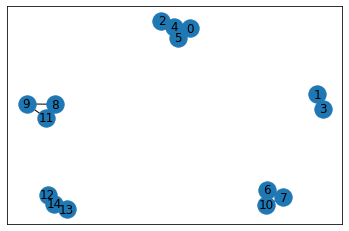

In [35]:
import matplotlib.pyplot as plt
nx.draw_networkx(g)
plt.show()

위에서 결과를 시각화했는데, 과연 어떠한 문서들 간에 군집화가 이루어진 것인지 역으로 다시 찾아야한다. 우리는 위에 있는 5개의 군집 각각을 component라고 일컫는데, 아래에서 nx.connected_components()를 이용하면 찾아낼 수 있게 된다.

In [32]:
list(nx.connected_components(g))

[{0, 2, 4, 5}, {1, 3}, {6, 7, 10}, {8, 9, 11}, {12, 13, 14}]

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(str(cluster_idf1.labels_).replace('[', '').replace(']', ''), 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

ValueError: could not convert string to float: '1 0 1 0 1 1 0 0 2 2 0 2 3 3 3'

In [41]:
str(cluster_idf1.labels_).replace('[', '').replace(']', '')

'1 0 1 0 1 1 0 0 2 2 0 2 3 3 3'